# The Transient Universe

In [1]:
import numpy as np
from scipy import stats, interpolate
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import optimize
plt.rcParams['figure.figsize'] = [4, 4]


from scipy.stats import cauchy
import emcee


In [2]:
x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
d_flux = x[:,2]

<ErrorbarContainer object of 3 artists>

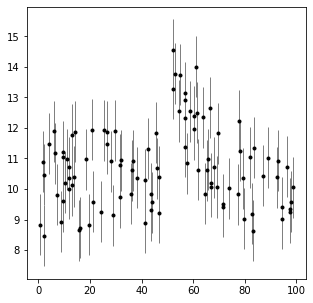

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='gray')


The data are homoscedastic

In [4]:
def model(t, x):
    b = x[0]
    A = x[1]
    to = x[2]
    alpha = x[3]
    if t < to:
        return b
    else: 
        return b + A*np.exp(-alpha*(t-to))


#likelihood assuming a gaussian flux[i]- model profuttoria exp(-(f-model)^2/sigma^2)

emcee wants function

In [5]:
def Likelihood(x, flux, d_flux ):
    # Gaussian likelihood 
    moo = []
    for i in range (len(time)):
        moo.append(model(time[i], x))
    moo = np.array(moo)
    return np.prod(np.exp(-(flux-moo)**2 /2/d_flux**2)) #il problema è time che è vettore nella funzione modulo


def Prior(x):
    p_b = 1.0/50
    p_A = 1.0/50
    p_to = 1.0/100
    p_alpha = 1.0/10 * x[3]
    return  p_b * p_A * p_to * p_alpha

def myPosterior(x, flux, d_flux):
    return Likelihood(x, flux, d_flux) * Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, flux, d_flux):
    return np.log(myPosterior(x, flux, d_flux))

In [29]:
ndim = 4  # number of parameters in the model
nwalkers = 24  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))
#starting_guesses = 5 * np.random.random((nwalkers, ndim)) +0
#starting_guesses = [20, 30, 67, 1]

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[flux, d_flux])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_11940\4141458179.py:22: RuntimeWarning: divide by zero encountered in log
  return np.log(myPosterior(x, flux, d_flux))


KeyboardInterrupt: 

In [7]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(24, 10000, 4)
(216000, 4)


In [8]:
print(emcee_trace)

[[0.5488135  0.71518937 0.60276338 0.54488318]
 [0.5488135  0.71518937 0.60276338 0.54488318]
 [0.5488135  0.71518937 0.60276338 0.54488318]
 ...
 [0.13179786 0.7163272  0.28940609 0.18319136]
 [0.13179786 0.7163272  0.28940609 0.18319136]
 [0.13179786 0.7163272  0.28940609 0.18319136]]


In [27]:
b = emcee_trace[:,0]
A = emcee_trace[:,1]
to = emcee_trace[:,2]
alpha = emcee_trace[:,3]
print(b)
print(A)
print(to)
print(alpha)


[0.5488135  0.5488135  0.5488135  ... 0.13179786 0.13179786 0.13179786]
[0.71518937 0.71518937 0.71518937 ... 0.7163272  0.7163272  0.7163272 ]
[0.60276338 0.60276338 0.60276338 ... 0.28940609 0.28940609 0.28940609]
[0.54488318 0.54488318 0.54488318 ... 0.18319136 0.18319136 0.18319136]


# Now take one point every autocorrelation lenght

In [10]:
# Now take one point every autocorrelation lenght
tau = sampler.get_autocorr_time()
print(tau)
#thin = int(tau+1)

C:\Users\LEONARDO\anaconda3\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


[nan nan nan nan]


In [11]:
#emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten()

NameError: name 'thin' is not defined

In [ ]:
len(emcee_trace)

In [ ]:
# plot 
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(15, 8))
#fig.subplots_adjust(left=0.11, right=0.95, 
                   # wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number',fontsize=15)
plt.ylabel('chain',fontsize=15)

# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean') 
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend(fontsize=15)

ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
#Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE, 
                                bins='auto', histtype='stepfilled',density=True)

# plot expectations based on central limit theorem
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)',fontsize=15)
ax2.set_xlabel('chain values',fontsize=15)
#ax2.set_xlim(0.7, 1.3)
#ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee',fontsize=15)